## Setup seurat object

In [1]:
# download example data
source('data.r')

In [2]:
library(dplyr)
library(Seurat)
library(patchwork)

# Load the PBMC dataset
pbmc.data <- Read10X(data.dir = "filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

## Standard pre-processing workflow
The steps below encompass the standard pre-processing workflow for scRNA-seq data in Seurat. These represent the selection and filtration of cells based on QC metrics, data normalization and scaling, and the detection of highly variable features.

In [3]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

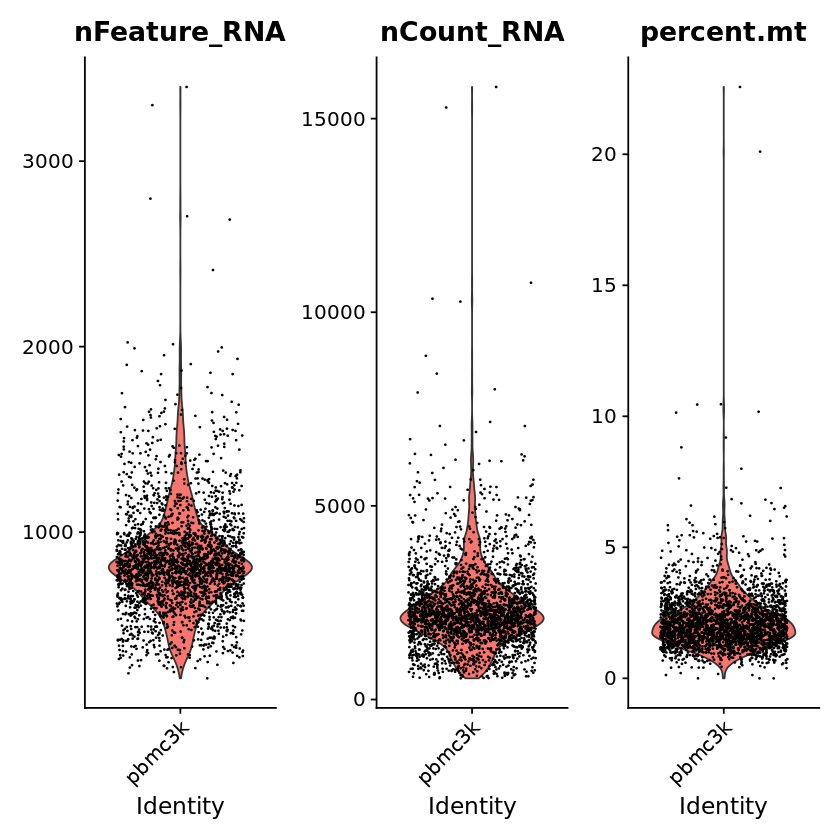

In [4]:
# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

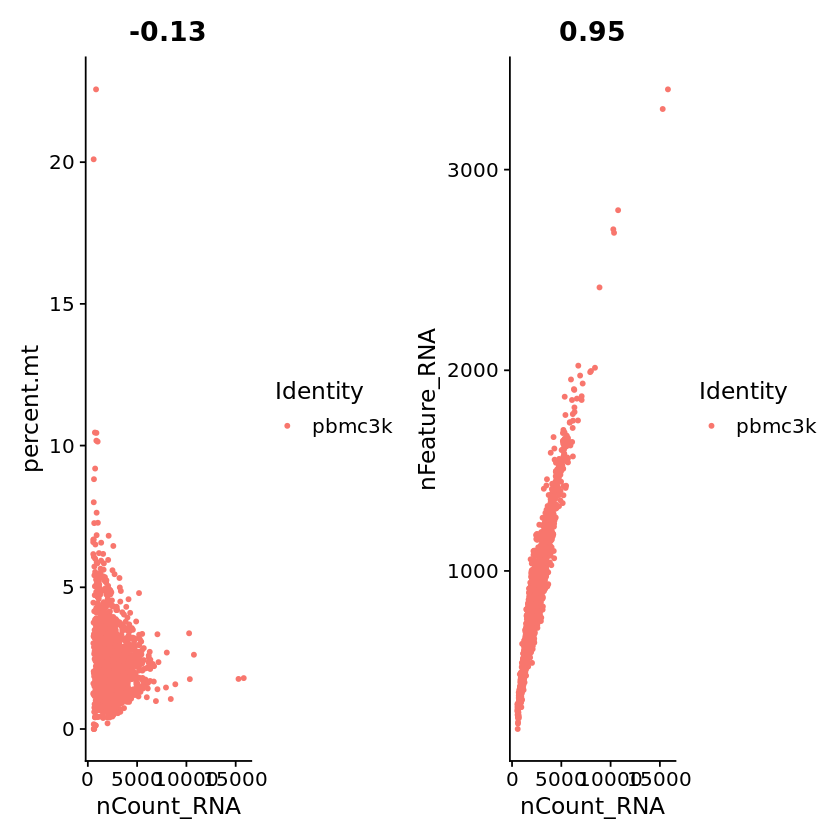

In [5]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [6]:
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

## Normalizing the data

In [7]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)
pbmc <- NormalizeData(pbmc)

## Identification of highly variable features (feature selection)

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
ERROR while rich displaying an object: Error in grid.Call(C_convert, x, as.integer(whatfrom), as.integer(whatto), : Viewport has zero dimension(s)

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(re

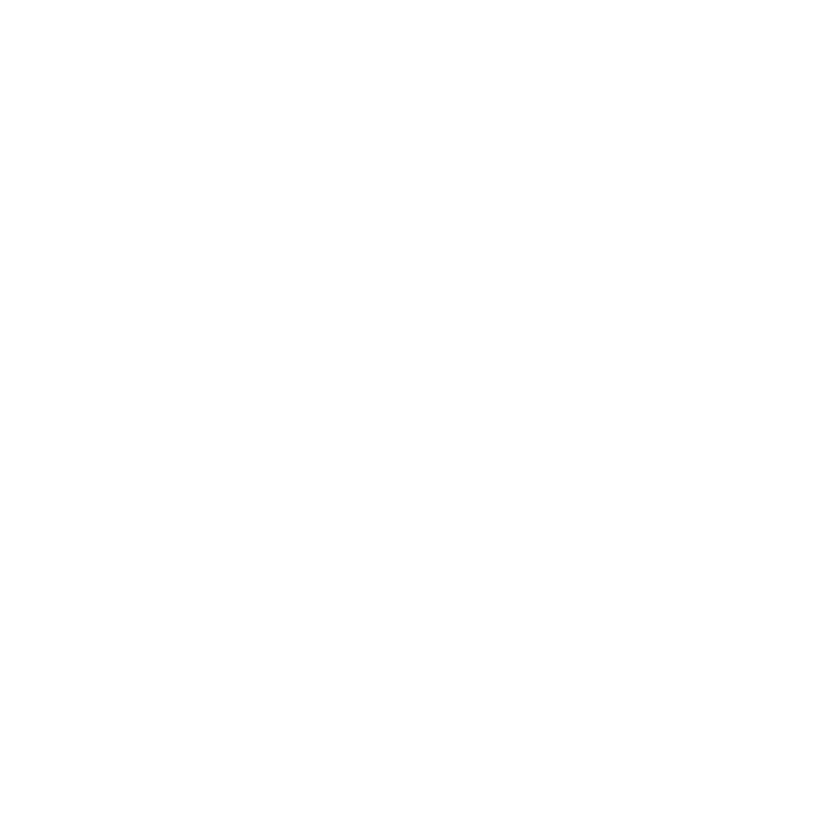

In [8]:
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

## Scaling the data

In [9]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



## Perform linear dimensional reduction

In [10]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))
# Examine and visualize PCA results a few different ways
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1 
Negative:  PPBP, PF4, SDPR, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, IL32, S100A8 
PC_ 5 
Positive:  GZMB, NKG7, S100A8, FGFBP2, GNLY 
Negative:  LTB, IL7R, CKB, VIM, MS4A7 


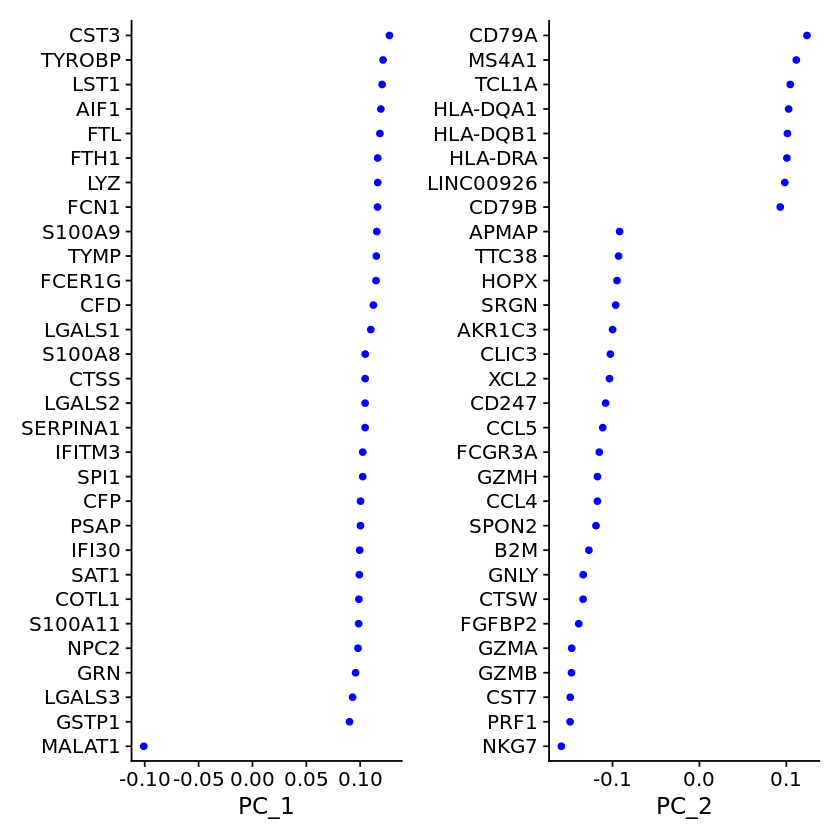

In [11]:
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

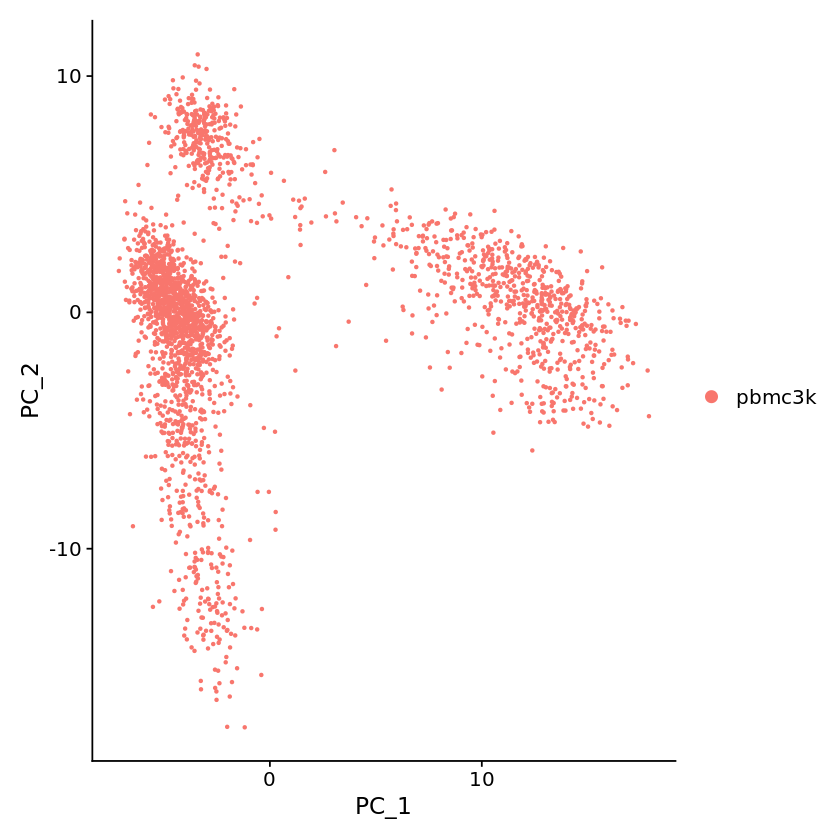

In [12]:
DimPlot(pbmc, reduction = "pca")

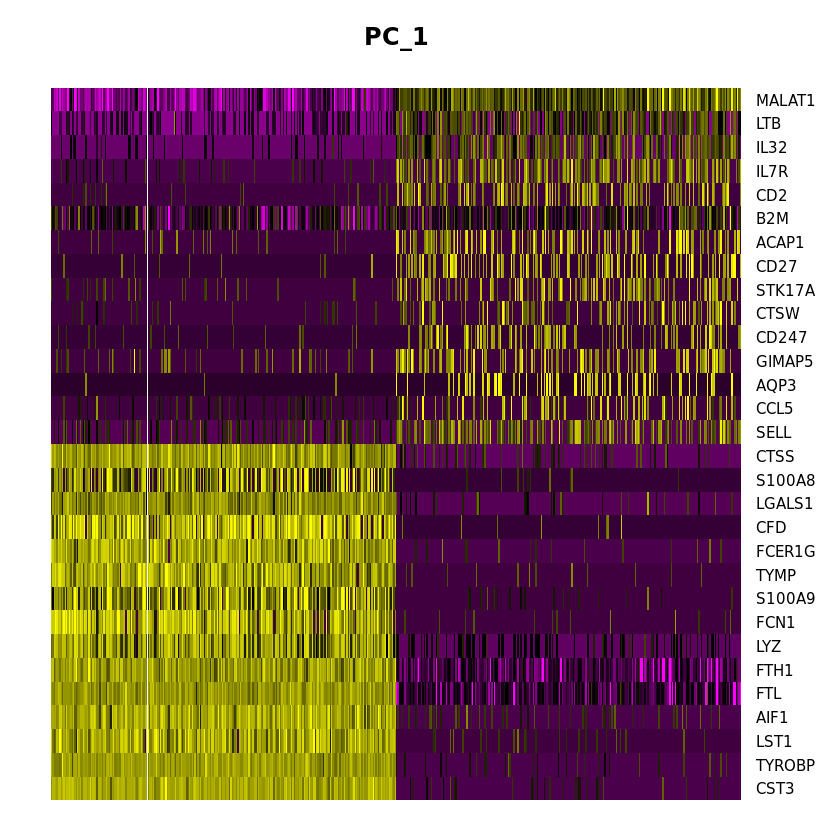

In [13]:
DimHeatmap(pbmc, dims = 1, cells = 500, balanced = TRUE)

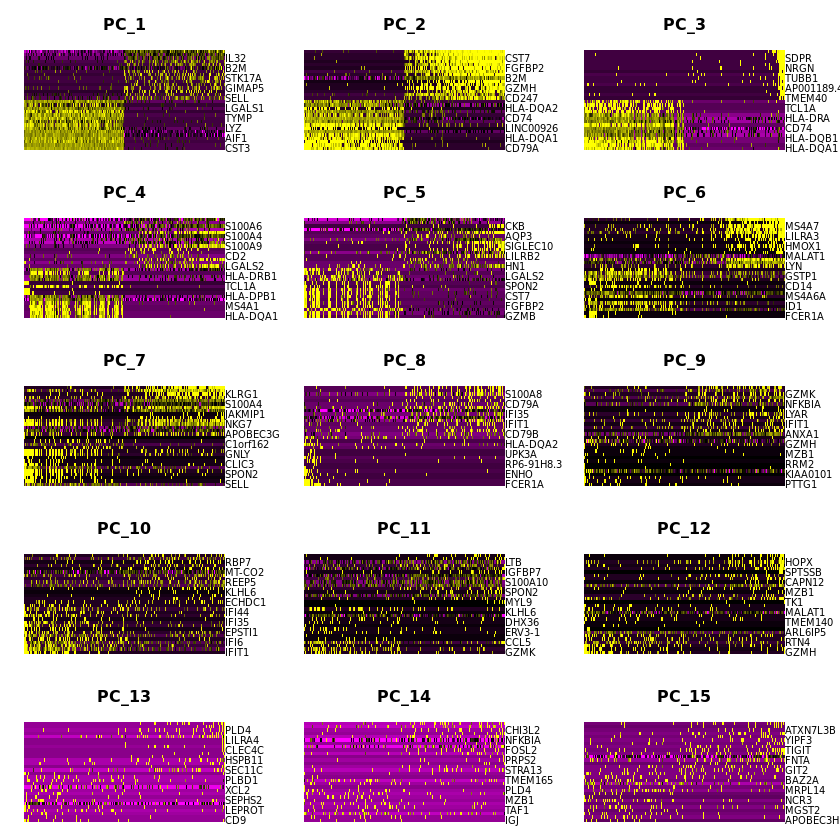

In [14]:
DimHeatmap(pbmc, dims = 1:15, cells = 500, balanced = TRUE)

## Determine the ‘dimensionality’ of the dataset

In [15]:
# NOTE: This process can take a long time for big datasets, comment out for expediency. More
# approximate techniques such as those implemented in ElbowPlot() can be used to reduce
# computation time
pbmc <- JackStraw(pbmc, num.replicate = 100)
pbmc <- ScoreJackStraw(pbmc, dims = 1:20)

Warning message:
“Removed 23516 rows containing missing values (geom_point).”


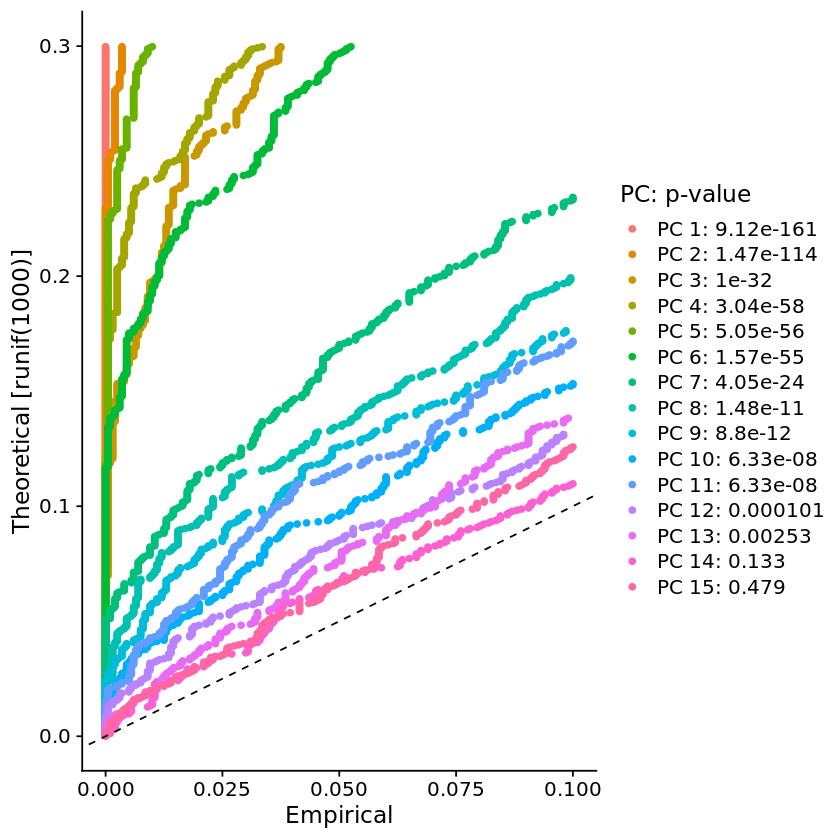

In [16]:
JackStrawPlot(pbmc, dims = 1:15)

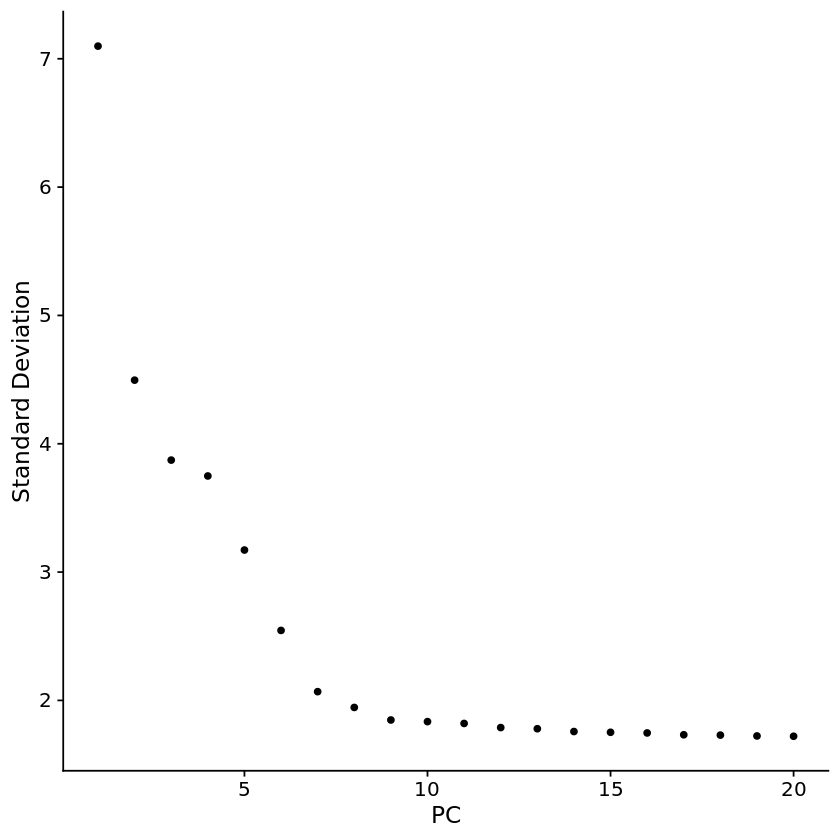

In [17]:
ElbowPlot(pbmc)

## Cluster the cells

In [18]:
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95965

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8723
Number of communities: 9
Elapsed time: 0 seconds


In [19]:
# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1 AAACCGTGCTTCCG-1 
               2                3                2                1 
AAACCGTGTATGCG-1 
               6 
Levels: 0 1 2 3 4 5 6 7 8

## Run non-linear dimensional reduction (UMAP/tSNE)

In [20]:
pbmc <- RunUMAP(pbmc, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:39:58 UMAP embedding parameters a = 0.9922 b = 1.112

10:39:58 Read 2638 rows and found 10 numeric columns

10:39:58 Using Annoy for neighbor search, n_neighbors = 30

10:39:58 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:39:58 Writing NN index file to temp file /tmp/RtmpBQx4cc/file73aa526c23be

10:39:58 Searching Annoy index using 1 thread, search_k = 3000

10:39:59 Annoy recall = 100%

10:39:59 Commencing smooth kNN distance calibration using 1 thread

10:39:59 Initializing fro

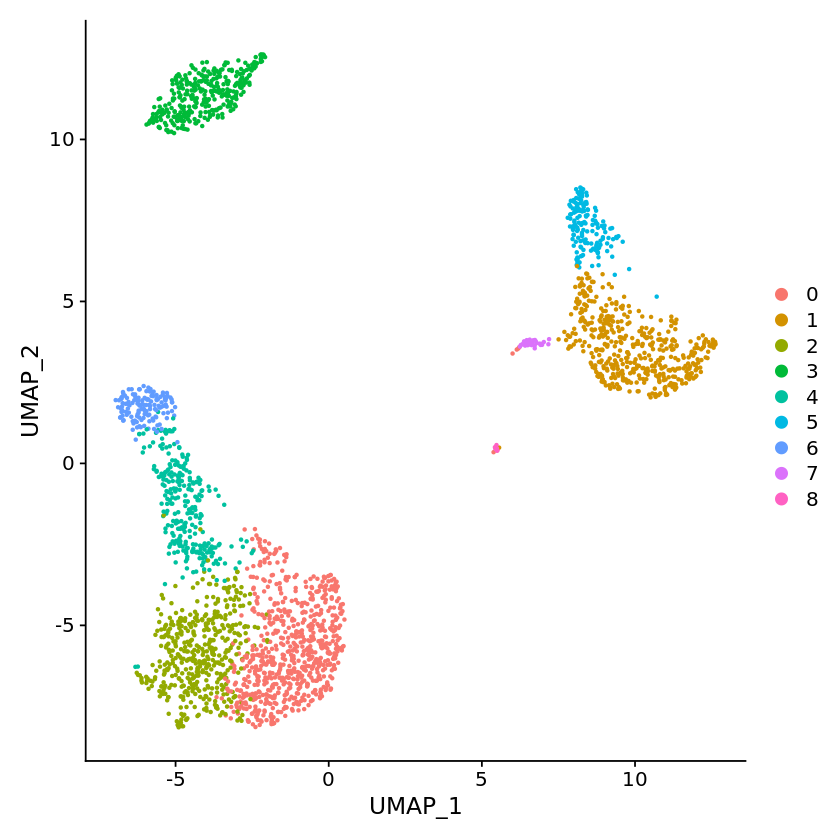

In [21]:
DimPlot(pbmc, reduction = "umap")

You can save the object at this point so that it can easily be loaded back in without having to rerun the computationally intensive steps performed above, or easily shared with collaborators.

In [22]:
saveRDS(pbmc, file = "pbmc_tutorial.rds")

## Finding differentially expressed features (cluster biomarkers)

In [23]:
# find all markers of cluster 1
cluster1.markers <- FindMarkers(pbmc, ident.1 = 1, min.pct = 0.25)
head(cluster1.markers, n = 5)

For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S100A9,0.000000e+00,5.570063,0.996,0.215,0.000000e+00
S100A8,0.000000e+00,5.477394,0.975,0.121,0.000000e+00
FCN1,0.000000e+00,3.394219,0.952,0.151,0.000000e+00
LGALS2,0.000000e+00,3.800484,0.908,0.059,0.000000e+00
CD14,2.856582e-294,2.815626,0.667,0.028,3.917516e-290


In [24]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
head(cluster5.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR3A,2.150929e-209,4.267579,0.975,0.039,2.949784e-205
IFITM3,6.103366e-199,3.877105,0.975,0.048,8.370156e-195
CFD,8.891428e-198,3.411039,0.938,0.037,1.219370e-193
CD68,2.374425e-194,3.014535,0.926,0.035,3.256286e-190
RP11-290F20.3,9.308287e-191,2.722684,0.840,0.016,1.276538e-186


In [ ]:
# find markers for every cluster compared to all remaining cells, report only the positive ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



In [ ]:
cluster1.markers <- FindMarkers(pbmc, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)

In [ ]:
VlnPlot(pbmc, features = c("MS4A1", "CD79A"))

In [ ]:
# you can plot raw counts as well
VlnPlot(pbmc, features = c("NKG7", "PF4"), slot = "counts", log = TRUE)

In [ ]:
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP", 
    "CD8A"))

In [ ]:
top10 <- pbmc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

## Assigning cell type identity to clusters

In [ ]:
new.cluster.ids <- c("Naive CD4 T", "Memory CD4 T", "CD14+ Mono", "B", "CD8 T", "FCGR3A+ Mono", 
    "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

In [ ]:
saveRDS(pbmc, file = "pbmc3k_final.rds")